# MNIST

Vamos a crear un modelo de **clasificación** de imágenes de dígitos escritos a mano. El objetivo es entrenar un modelo que sea capaz de reconocer qué dígito es el que aparece en la imagen.

Para ello, utilizaremos [la base de datos MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST), que contiene 70,000 imágenes de dígitos escritos a mano.

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)
X, y

(70000, 784)
(70000,)


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

El método `fetch_openml` de Scikit-Learn permite recuperar *datasets* de [openml](https://www.openml.org/) directamente.

Hay que tener en cuenta que cuando queremos trabajar con imágenes, antes de nada tenemos que comprender en qué formato están almacenadas, y probablemente hacer un procesado de estas imágenes. En este caso, el *dataset* se nos presenta ya preprocesado, con las imágenes normalizadas en 28x28 píxeles y en escala de grises.

La base de datos está dividida en 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Cada fila tiene la imagen codificada en 784 columnas, cada una de las cuales es uno de los píxeles ordenados (28x28 píxeles), y una columna adicional con la etiqueta del dígito que representa la imagen.

Hemos utilizado el parámetro `as_frame=False` para que los datos se en un array de NumPy y no en un DataFrame, ya que el nombre de las 784 columnas no aporta información relevante en este caso, cada una se corresponde simplemente con uno de los píxeles de la imagen en orden.

Cada píxel tiene un valor que representa la intensidad en escala de grises, entre 0 (blanco) y 255 (negro).

In [29]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28) # convertimos los 784 píxeles a una matriz de 28x28
    plt.imshow(image, cmap="binary") # muestra el array como una imagen
    plt.axis("off")
    plt.show()

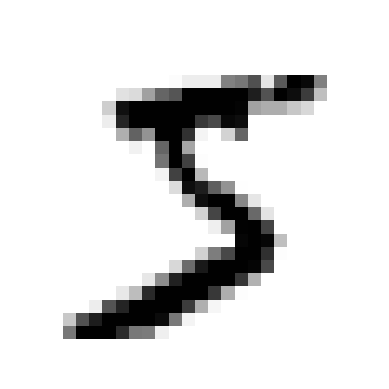

'5'

In [30]:
index=0
some_digit = X[index]
plot_digit(some_digit)
y[index] # Vemos que está correctamente etiquetada

Este dataset tradicionalmente define que las 60000 primeras muestras son de entrenamiento y las últimas 10000 de test.

In [31]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Entrenando un clasificador binario

Vamos inicialmente a crear un modelo que simplemente clasifique si un dígito es 5 o no lo es.

In [32]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Vamos a utilizar, por ejemplo, un clasificador `SGDClassifier`. Este clasificador implementa un descenso estocástico de graciente o *Stochastic Gradient Descent* (una aproximación al [descenso de gradiente](https://www.youtube.com/watch?v=A6FiCDoz8_4) que busca ser menos costosa computacionalmente) sobre algún algoritmo lineal de *machine learning* como regresión lineal o máquinas de vector soporte (SVM). Por defecto utiliza SVM.

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [34]:
sgd_clf.predict([some_digit])

array([ True])

## Exactitud (*Accuracy*) usando *Cross-Validation*

Vamos a utilizar la función `cross_val_score` para calcular la *exactitud (el porcentaje de aciertos)* de nuestro modelo mediante validación cruzada.

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Parece que nuestro modelo es muy bueno, ya que acierta en más de un 95% de las ocasiones.

Sin embargo, veamos qué sucede si utilizamos un clasificador cuyo único algoritmo consiste en devolver siempre la etiqueta más frecuente. En este caso, dado que la mayoría de etiquetas son `False` (o sea, la mayoría no eran `'5'`), este modelo siempre clasificará como `False`.

In [36]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # Siempre devuelve false

False


In [37]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Nos encontramos con que este modelo tan absurdamente simple tiene un porcentaje de aceirtos del 90%. Pero claro, eso se debe a que efectivamente, solo un 10% de las muestras eran '5' (tenemos 10 dígitos distribuidos uniformemente). Nuestro `DummyClassifier` acierta para todos los valores que no son 5, que al ser la mayoría nos da una exactitud alta (no hay falsos positivos). Pero no acierta ninguno de los que sí.

Con este ejemplo queda patente la necesidad de mejores métricas de rendimiento en problemas de clasificación que simplemente la exactitud. <!--TODO: especialmente para datasets desbalanceados? asimétricos? poco uniformes?-->

## Matriz de confusión

Una matriz de confusión es una forma de visualizar el rendimiento de un algoritmo de clasificación. Cada fila representa una clase real, mientras que cada columna representa una clase predicha. Los elementos de la diagonal principal representan las predicciones correctas, mientras que los elementos fuera de la diagonal principal representan las predicciones incorrectas.

Hemos reservado el conjunto de test para la evaluación final del modelo. pero la función `cross_val_predict` nos permite obtener las predicciones de cada instancia en el conjunto de entrenamiento mediante validación cruzada.

In [38]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # predicciones

y con ellas podremos construir una matriz de confusión.

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

donde la primera fila indica los negativos (no 5) y la segunda los positivos (5). La primera columna indica los negativos predichos y la segunda los positivos predichos. Así, la matriz contabiliza 53892 verdaderos negativos, 687 falsos positivos, 1891 falsos negativos y 3530 verdaderos positivos.

Para clarificar, imaginemos cual sería la matriz de confusión para un clasificador perfecto.

In [40]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

Observamos cómo desaparecen los falsos positivos y los falsos negativos, y solo quedan los verdaderos positivos (5421) y los verdaderos negativos (54579) . El clasificador sería perfecto.

## Precisión y *recall* (exahustividad)

La precisión de un clasificador es la cantidad de predicciones correctas dividida por el total de predicciones positivas, o sea: el porcentaje de predicciones positivas que son correctas.

$$ \text{Precisión} = \frac{TP}{TP + FP} $$

La exahustividad o *recall* es la cantidad de predicciones correctas dividida por el total de instancias que deberían haber sido predichas como positivas, o sea: el porcentaje de positivos (valores que son '5') correctamente predichos. También se llama *sensibilidad* o *tasa de verdaderos positivos*.

$$ \text{Exahustividad} = \frac{TP}{TP + FN} $$

[![](img/classfication_metrics.jpg)](https://medium.com/swlh/how-to-remember-all-these-classification-concepts-forever-761c065be33)

![precision_recall](img/mnist-precision-recall.png)

In [41]:
from sklearn.metrics import precision_score, recall_score

print("Precisión:", precision_score(y_train_5, y_train_pred)) # == 3530 / (687 + 3530)
print("Precisión:", cm[1, 1] / (cm[0, 1] + cm[1, 1])) # manualmente sobre la matriz de confusión
print("Recall:", recall_score(y_train_5, y_train_pred)) # == 3530 / (1891 + 3530)

Precisión: 0.8370879772350012
Precisión: 0.8370879772350012
Recall: 0.6511713705958311


Vemos que nuestro clasificador, pese a tener una gran exactitud, solo está acertado un 83,7% de las veces que dice que un dígito es un '5'. Y solo detecta el 65,1% de los '5'. Esta métrica solo será alta cuando tanto la precisión como la exahustividad sean altas.

Existe otra métrica muy popular que es la media armónica entre precisión y exactitud, el *F1 Score*:

$$ F1 = \frac{2}{\frac{1}{\text{Precisión}} + \frac{1}{\text{Exahustividad}}} = 2 \times \frac{\text{Precisión} \times \text{Exahustividad}}{\text{Precisión} + \text{Exahustividad}} = \frac{TP}{TP + \frac{FN + FP}{2}} $$

In [42]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

En algunos contextos se prefiere la precisión, en otros la exahustividad. Por ejemplo, si entrenamos un clasificador para detectar vídeos seguros para niños, probablemente prefiramos un clasificador que rechace muchos vídeos buenos (baja exahustividad) pero que mantenga solo los seguros (alta precisión). Por otro lado, si entrenamos un clasificador para detectar ladrones en imágenes de vigilancia, probablemente esté bien si nuestro clasificador solo tiene un 30% de precisión (muchas falsas alarmas) siempre que tenga un 99% de exahustividad.

En general, cuanto mayor sea la precisión, menor será la exahustividad, y viceversa. Esto se llama el ***trade-off* entre precisión y exahustividad**.

Para mostrar todas las métricas de un clasificador, podemos utilizar la función `classification_report`.

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     54579
        True       0.84      0.65      0.73      5421

    accuracy                           0.96     60000
   macro avg       0.90      0.82      0.85     60000
weighted avg       0.95      0.96      0.95     60000



## Clasificación multiclase

Existen clasificadores que pueden manejar múltiples clases directamente, como la regresión logística o los árboles de decisión. Otros clasificadores son estrictamente binarios, como las máquinas de vector soporte. Sin embargo, existen estrategias para extenderlos a clasificadores multiclase.

Existen principalmente dos estrategias para extender un clasificador binario a un clasificador multiclase:

- ***One-versus-the-rest* (OvR)** o *One-versus-all* (OvA): Entrenar un clasificador binario por cada clase. Cuando queremos clasificar una instancia, obtenemos la puntuación de decisión de cada clasificador y seleccionamos la clase cuya puntuación sea la más alta. En este caso, entrenaríamos 10 clasificadores binarios, uno para cada dígito, análogos al que hemos entrenado para clasificar si un dígito es 5 o no.

- ***One-versus-one* (OvO)**: Entrenar un clasificador binario para cada par de clases. Si hay N clases, necesitamos entrenar N * (N - 1) / 2 clasificadores: 1 para distinguir 0 y 1, otro para distinguir 0 y 2, otro para distinguir 1 y 2, etc. La clase que gana la mayoría de los duelos es la que se selecciona. Este método necesita entrenar muchos más clasificadores que el anterior, pero cada uno solo necesita ser entrenado en una parte del conjunto de entrenamiento.

Scikit-learn detecta automáticamente si estamos intentando usar un clasificador binario para una tarea de clasificación multiclase y aplica una u otra estrategia en función del algoritmo (normalmente OvA, salvo para algoritmos que escalan mal con el incremento, como SVM)

Vamos a probar el classificador SVC, que aplica *Support Vector Machine* usando OvO para clasificación multiclase. Para que no tarde mucho tiempo, entrenaremos solo las primeras 2000 instancias.

In [44]:
from sklearn.svm import SVC # Support Vector Classifier, usando OvO

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [45]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

También es posible forzar el uso una u otra técnica con los clasificadores de Scikit-learn, utilizando las clases `OneVsOneClassifier` o `OneVsRestClassifier`.

In [46]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [47]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

Hemos utilizado SVM con OvO por defecto y OVR forzado. También podemos volver a utilizar SGDClassifier, que también aplica OvR por defecto.

In [48]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train[:2000], y_train[:2000])
sgd_clf.predict([some_digit])

array(['5'], dtype='<U1')

En este caso se ha equivocado. Vamos a comparar el rendimiendo en general de las 3 técnicas.

In [49]:
nsamples = 10000 # probar a variar el número de muestras

In [50]:
print("SVC por defecto (SVM-OvO):",
      cross_val_score(svm_clf, X_train[:nsamples], y_train[:nsamples], cv=3, scoring="accuracy").mean())

SVC por defecto (SVM-OvO): 0.9551998991140866


In [51]:
print("SVC con OvR:",
    cross_val_score(ovr_clf, X_train[:nsamples], y_train[:nsamples], cv=3, scoring="accuracy").mean())

SVC con OvR: 0.9538997391040844


In [52]:
print("SVC por defecto optimizado con SGD:",
    cross_val_score(sgd_clf, X_train[:nsamples], y_train[:nsamples], cv=3, scoring="accuracy").mean())

SVC por defecto optimizado con SGD: 0.8633997472932656


Vemos que OvR es mucho más costoso computacionalmente conforme aumenta el número de muestras. Por eso SVC aplica OvO por defecto. Por su parte SGDClassifier es más rápido, pero menos eficiente.